In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
from data_src import test, families

In [4]:
families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [5]:
df = pd.read_csv('data/train.csv')

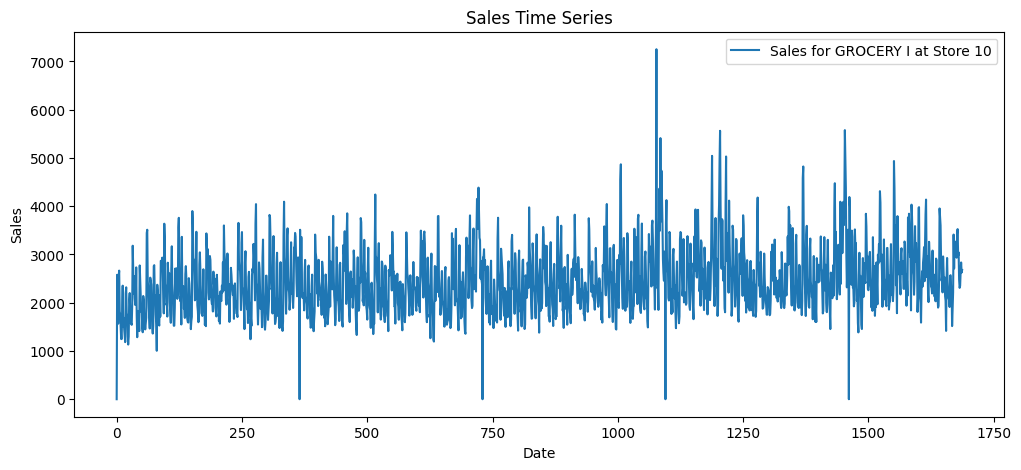

In [6]:
store_number = 10  # Change this to the desired store
product_family = "GROCERY I"  # Change this to the desired product family

df_filtered = df[(df["store_nbr"] == store_number) & (df["family"] == product_family)].copy()

# Set the date as the index
dates_dt = pd.to_datetime(df_filtered['date'])
dates_dt_min = dates_dt.min()
days = (dates_dt - dates_dt_min).dt.days
df_filtered['day'] = days
df_filtered.set_index("day", inplace=True)

# Keep only the sales column
# df_filtered = df_filtered[["sales"]]

# Sort
df_filtered = df_filtered.sort_index()

# Visualize sales over time
plt.figure(figsize=(12, 5))
plt.plot(df_filtered["sales"], label=f"Sales for {product_family} at Store {store_number}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Time Series")
plt.legend()
plt.show()

ADF Statistic: -6.071949674558721
p-value: 1.1452419390349338e-07
The data is stationary.
ADF Statistic: -15.634152606695531
p-value: 1.6710943913707734e-28
The data is stationary.


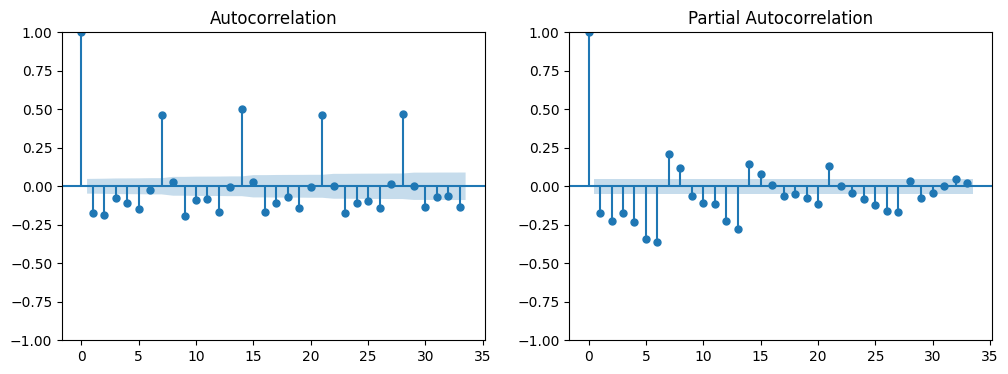

In [7]:
# This is the implementation of the ARIMA model(this model does not take into account promotion data nor oil prizes, to be modified accordingly)

# First we check if the data is stationary; for it take the following function based on the Augmented Dickey-Fuller (ADF) Test (here DataTrain is replaced with "df" for simplicity, as is the rest of the code)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary. Differencing must be done.")

# Run the ADF test
adf_test(df_filtered["sales"])


# Carry out differencing

df_filtered["sales_diff"] = df_filtered["sales"].diff().dropna()
adf_test(df_filtered["sales_diff"].dropna())  


# Determine ARIMA parameters(for it we need these plots)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_filtered["sales_diff"].dropna(), ax=axes[0])  # q value (MA component)
plot_pacf(df_filtered["sales_diff"].dropna(), ax=axes[1])  # p value (AR component)
plt.show()

C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1683
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -12947.156
Date:                Sun, 16 Feb 2025   AIC                          25912.311
Time:                        10:17:15   BIC                          25961.161
Sample:                             0   HQIC                         25930.405
                               - 1683                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7010      0.038     18.602      0.000       0.627       0.775
ar.L2          0.0564      0.057      0.991      0.322      -0.055       0.168
ar.L3         -1.0159      0.055    -18.608      0.0

C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


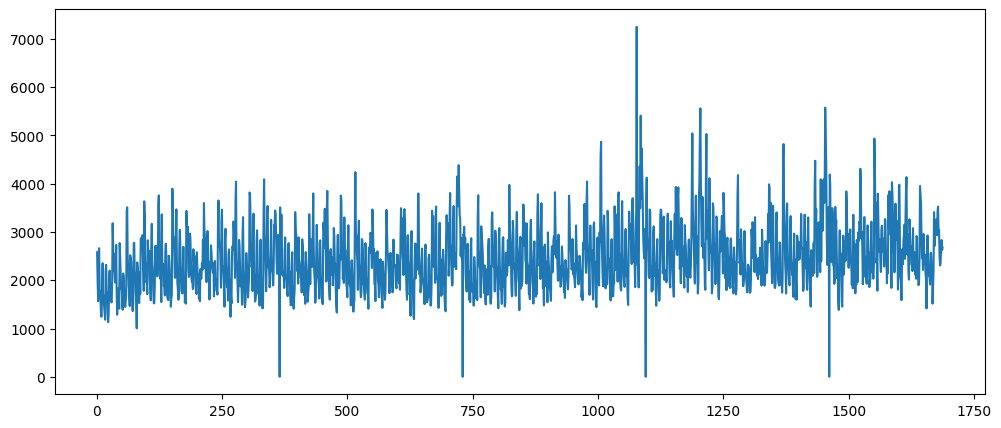

In [16]:
# fit model

p, d, q = 4, 1, 4  # Adjust based on ACF/PACF values above, most likely not these

model = ARIMA(df_filtered["sales"], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


# To make predictions we forecast after N days

# Forecasting 30 days into the future
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Create future dates in dates format
future_dates = pd.date_range(start=df_filtered.index[-1], periods=forecast_steps + 1, freq="D")[1:]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({"date": future_dates, "predicted_sales": forecast.values})

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_filtered.index, df_filtered["sales"], label="Historical Sales")
# plt.plot(forecast_df["date"], forecast_df["predicted_sales"], label="Forecast", linestyle="dashed", color="red")
# plt.xlabel("Date")
# plt.ylabel("Sales")
# plt.title(f"Sales Forecast for {product_family} at Store {store_number}")
# plt.legend()
# plt.show()

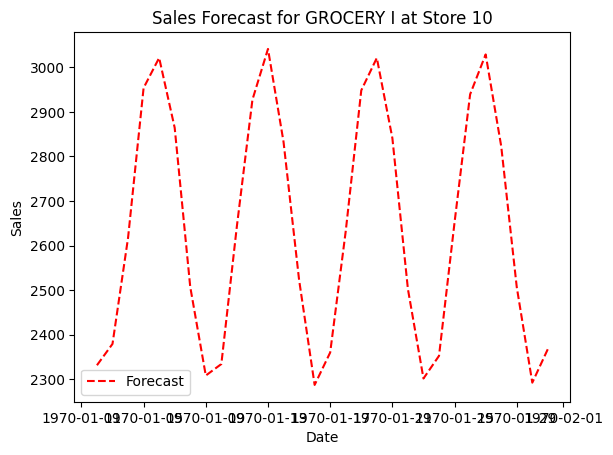

In [17]:
plt.plot(forecast_df["date"], forecast_df["predicted_sales"], label="Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Sales Forecast for {product_family} at Store {store_number}")
plt.legend()
plt.show()

In [18]:
test_filtered = test[(test["store_nbr"] == store_number) & (test["family"] == product_family)].copy()
future_promo_status = test_filtered['onpromotion'].values

In [19]:
# Get residuals (errors ARIMA needed for the neural net)
df_filtered["residuals"] = df_filtered["sales"] - model_fit.fittedvalues

In [20]:
df_filtered

,id,date,store_nbr,family,sales,onpromotion,sales_diff,residuals
day,,,,,,,,
1,1827,2013-01-02,10,GROCERY I,2579.0,0,2579.0,2579.000000
2,3609,2013-01-03,10,GROCERY I,1984.0,0,-595.0,-487.293780
3,5391,2013-01-04,10,GROCERY I,1565.0,0,-419.0,-317.876999
4,7173,2013-01-05,10,GROCERY I,2544.0,0,979.0,1039.125761
5,8955,2013-01-06,10,GROCERY I,2665.0,0,121.0,366.939325
...,...,...,...,...,...,...,...,...
1683,2992023,2017-08-11,10,GROCERY I,2349.0,44,41.0,-313.476517
1684,2993805,2017-08-12,10,GROCERY I,2629.0,46,280.0,-164.341376
1685,2995587,2017-08-13,10,GROCERY I,2834.0,51,205.0,-126.110043


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Train the net on the residuals

# Prepare dataset for MLP

df_filtered.dropna(inplace=True)  # Remove NaN values from ARIMA residuals
X = df_filtered["onpromotion"].values  # Use promotion as predictor
y = df_filtered["residuals"].values  # Target: ARIMA residuals

# Scale features for better NN performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1))

In [22]:
forecast[16:]

1699    2632.133195
1700    2948.470390
1701    3021.289352
1702    2841.255517
1703    2502.111199
1704    2301.360584
1705    2352.279956
1706    2652.252146
1707    2939.492199
1708    3029.175400
1709    2823.002921
1710    2506.585230
1711    2292.018164
1712    2367.545530
Name: predicted_mean, dtype: float64

ARIMA MAE: 508.92
Hybrid Model MAE: 497.18


C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nilsen\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


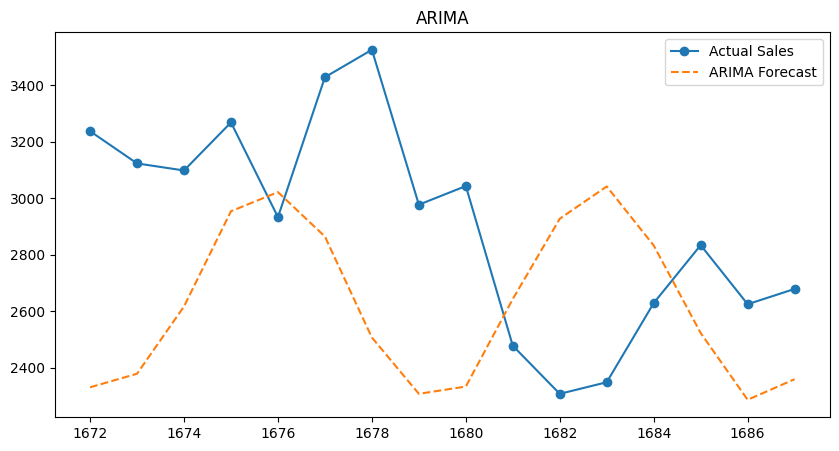

In [24]:
from sklearn.neural_network import MLPRegressor

# Train MLP Model
mlp = MLPRegressor(hidden_layer_sizes=(75, 75, 75), max_iter=1000, random_state=42)
mlp.fit(X_scaled, y)

# Combine the two for the final forecast

# Forecast ARIMA residual corrections using MLP
# future_promo_status =   # Replace with real promotion data from data
future_promo_scaled = scaler.transform(future_promo_status.reshape(-1, 1))  # Scale promotion feature(scaled data works well in neural nets)

# Predict corrections
mlp_correction = mlp.predict(future_promo_scaled)

# Final hybrid forecast = ARIMA forecast + MLP correction
final_forecast = forecast[:16] + mlp_correction

forecast_steps = 16

# Evaluate

# Predictions on actual test data
y_test = df_filtered["sales"].iloc[-forecast_steps:]  # Last 30 days for testing
y_pred_arima = model_fit.forecast(steps=forecast_steps)  # ARIMA-only predictions
y_pred_hybrid = y_pred_arima + mlp.predict(X_scaled[-forecast_steps:])  # Hybrid model

# Compute errors
mae_arima = mean_absolute_error(y_test, y_pred_arima)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)

print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"Hybrid Model MAE: {mae_hybrid:.2f}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual Sales", marker="o")
plt.plot(y_test.index, y_pred_arima, label="ARIMA Forecast", linestyle="dashed")
# plt.plot(y_test.index, y_pred_hybrid, label="Hybrid Forecast", linestyle="dashed", marker="x")
plt.legend()
plt.title("ARIMA")
plt.show()






